In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ollama
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from datasets import load_dataset
from tqdm import tqdm
import torch

import warnings
warnings.filterwarnings('ignore')


/Users/surya/University/Shimmy/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [2]:
data_path_1 = 'data/shimmy/raw_data.csv'
data_path_2 = 'cardiffnlp/tweet_eval'
shimmy_df = pd.read_csv(data_path_1)
cdf_twitter_df = pd.DataFrame(load_dataset(data_path_2, 'sentiment', split='test'))

In [3]:
shimmy_df['label'] = shimmy_df['Category'].apply(lambda x: 2 if x in [1, 2] else (1 if x in [4, 5] else 0))
shimmy_df['label'].value_counts()

label
2    335
1    271
0    130
Name: count, dtype: int64

In [4]:
print("Shimmy Data: \n", shimmy_df['label'].value_counts().sort_index())
print()
print("CDF Twitter: \n", cdf_twitter_df['label'].value_counts().sort_index())

Shimmy Data: 
 label
0    130
1    271
2    335
Name: count, dtype: int64

CDF Twitter: 
 label
0    3972
1    5937
2    2375
Name: count, dtype: int64


## Process Functions

In [5]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [6]:
def display_metrics(ytrue, ypred):
  print("Accuracy Score: ", accuracy_score(ytrue, ypred))
  print(classification_report(ytrue, ypred))
  sns.heatmap(confusion_matrix(ytrue, ypred), annot=True, fmt='g')

## Data Visualization

##### Category Distribution

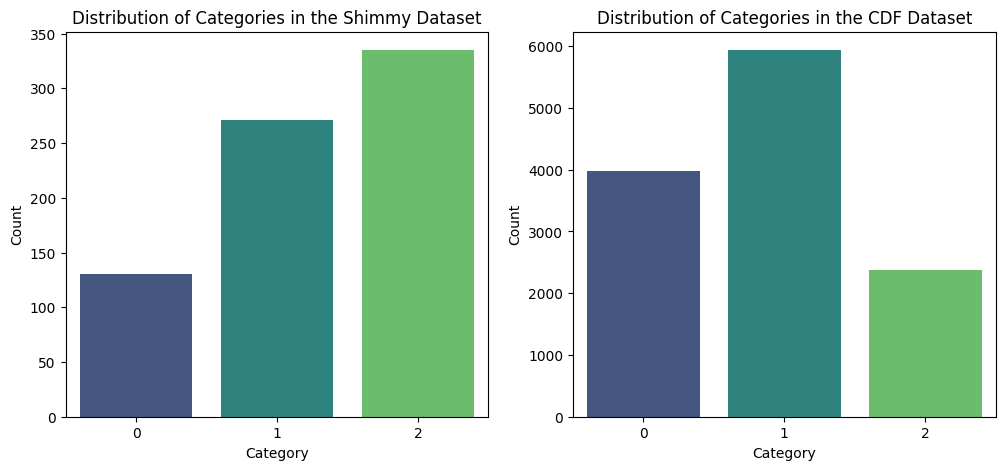

In [7]:
sh_category_counts = shimmy_df["label"].value_counts().sort_index()
cdf_category_counts = cdf_twitter_df['label'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=sh_category_counts.index, y=sh_category_counts.values, palette="viridis", ax=axes[0])
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Categories in the Shimmy Dataset")
axes[0].set_xticks(ticks=sh_category_counts.index)

sns.barplot(x=cdf_category_counts.index, y=cdf_category_counts.values, palette='viridis', ax=axes[1])
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of Categories in the CDF Dataset")
axes[1].set_xticks(ticks=cdf_category_counts.index)

## RoBERT-A

In [8]:
# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# config = AutoConfig.from_pretrained(MODEL)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained('latest-model')
# tokenizer.save_pretrained('latest-tokenizer')

In [9]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [10]:
model = AutoModelForSequenceClassification.from_pretrained('latest-model').to(device)
tokenizer = AutoTokenizer.from_pretrained('latest-tokenizer')

In [11]:
def get_sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
        # scores = output[0][0].detach().numpy()
        scores = output[0][0].cpu().detach().numpy()
        scores = softmax(scores)
        predicted_category = np.argmax(scores)
    return predicted_category

In [15]:
shimmy_test, shimmy_label = shimmy_df['Text'], shimmy_df['label']
cdf_df_mini = cdf_twitter_df.sample(1000, random_state=42)
cdf_test, cdf_label = cdf_df_mini['text'], cdf_df_mini['label']

shimmy_pred, cdf_pred = [], []

In [16]:
print("Model Run on Shimmy Data")
for text in tqdm(shimmy_test, desc='Processing Texts: '):
    pred_category = get_sentiment(text)
    shimmy_pred.append(pred_category)

print("Model Run on CDF Data")
for text in tqdm(cdf_test, desc='Processing Texts: '):
    pred_category = get_sentiment(text)
    cdf_pred.append(pred_category)

Model Run on Shimmy Data


Processing Texts: 100%|██████████| 736/736 [00:11<00:00, 61.41it/s]


Model Run on CDF Data


Processing Texts: 100%|██████████| 1000/1000 [00:17<00:00, 56.96it/s]


Shimmy Data Metrics
Accuracy Score:  0.3763586956521739
              precision    recall  f1-score   support

           0       0.26      0.98      0.41       130
           1       0.27      0.11      0.16       271
           2       0.92      0.36      0.51       335

    accuracy                           0.38       736
   macro avg       0.48      0.48      0.36       736
weighted avg       0.56      0.38      0.36       736



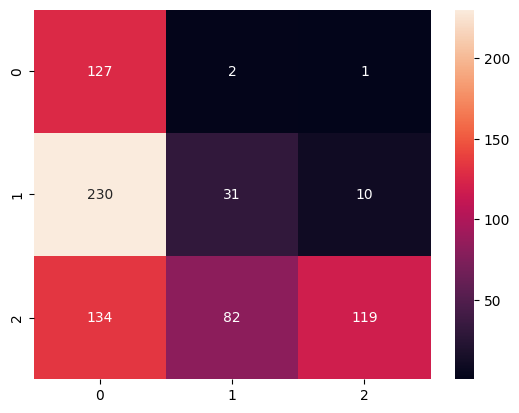

In [17]:
print('Shimmy Data Metrics')
display_metrics(shimmy_label, shimmy_pred)

CDF Data Metrics
Accuracy Score:  0.7
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       328
           1       0.72      0.63      0.67       462
           2       0.69      0.70      0.70       210

    accuracy                           0.70      1000
   macro avg       0.70      0.71      0.70      1000
weighted avg       0.70      0.70      0.70      1000



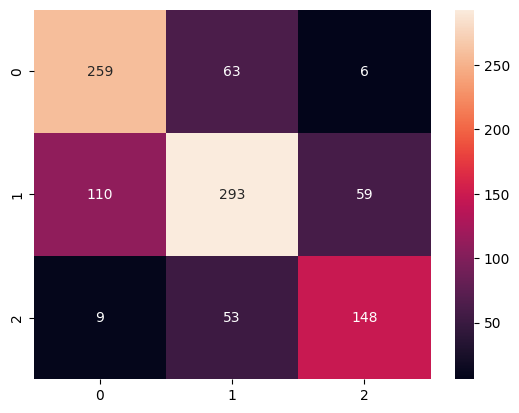

In [18]:
print('CDF Data Metrics')
display_metrics(cdf_label, cdf_pred)

# XLM-RoBERT-a

In [19]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
# model.save_pretrained('latest-model')
# tokenizer.save_pretrained('latest-tokenizer')

In [20]:
def get_sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
        # scores = output[0][0].detach().numpy()
        scores = output[0][0].cpu().detach().numpy()
        scores = softmax(scores)
        predicted_category = np.argmax(scores)
    return predicted_category

In [21]:
shimmy_pred, cdf_pred = [], []

print("Model Run on Shimmy Data")
for text in tqdm(shimmy_test, desc='Processing Texts: '):
    pred_category = get_sentiment(text)
    shimmy_pred.append(pred_category)

print("Model Run on CDF Data")
for text in tqdm(cdf_test, desc='Processing Texts: '):
    pred_category = get_sentiment(text)
    cdf_pred.append(pred_category)

Model Run on Shimmy Data


Processing Texts: 100%|██████████| 736/736 [00:13<00:00, 55.26it/s]


Model Run on CDF Data


Processing Texts: 100%|██████████| 1000/1000 [00:17<00:00, 56.80it/s]


Shimmy Data Metrics
Accuracy Score:  0.360054347826087
              precision    recall  f1-score   support

           0       0.24      0.88      0.37       130
           1       0.26      0.10      0.15       271
           2       0.87      0.36      0.51       335

    accuracy                           0.36       736
   macro avg       0.45      0.45      0.34       736
weighted avg       0.53      0.36      0.35       736



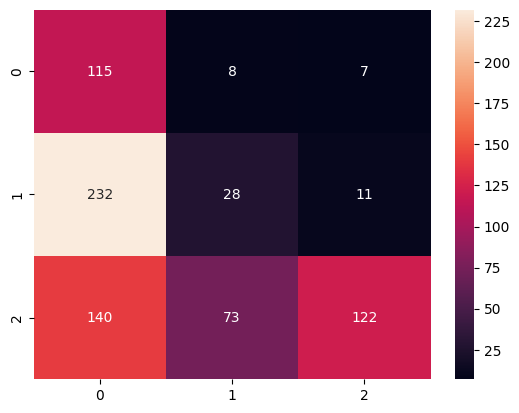

In [22]:
print('Shimmy Data Metrics')
display_metrics(shimmy_label, shimmy_pred)

CDF Data Metrics
Accuracy Score:  0.646
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       328
           1       0.71      0.49      0.58       462
           2       0.64      0.62      0.63       210

    accuracy                           0.65      1000
   macro avg       0.65      0.66      0.64      1000
weighted avg       0.66      0.65      0.64      1000



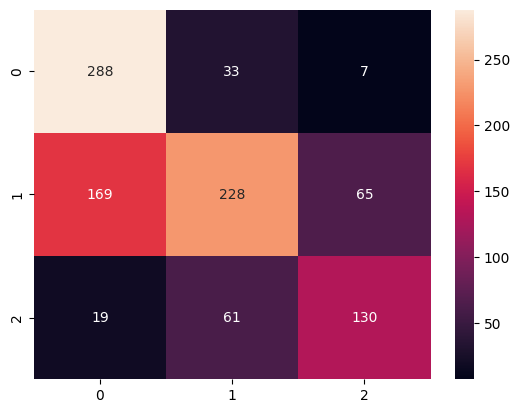

In [23]:
print('CDF Data Metrics')
display_metrics(cdf_label, cdf_pred)

# Gemma3

In [24]:
def classify_with_ollama(text):
    prompt = f"""
    Classify the following text into one of the three categories (0, 1, 2):
    - Category 0: Moderately or Strongly Negative
    - Category 1: Neutral or Slightly Negative
    - Category 2: Safe, Positive, Not harmful

    Text: "{text}"

    Respond with only a single integer from 0 to 2.
    """
    
    response = ollama.chat(model="gemma3:4b", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"].strip() 

In [25]:
tqdm.pandas()
shimmy_pred = shimmy_df['Text'].progress_apply(classify_with_ollama)
shimmy_pred = shimmy_pred.astype(int)

100%|██████████| 736/736 [03:36<00:00,  3.40it/s]


Shimmy Data Metrics
Accuracy Score:  0.33967391304347827
              precision    recall  f1-score   support

           0       0.25      0.98      0.40       130
           1       0.00      0.00      0.00       271
           2       0.98      0.36      0.53       335

    accuracy                           0.34       736
   macro avg       0.41      0.45      0.31       736
weighted avg       0.49      0.34      0.31       736



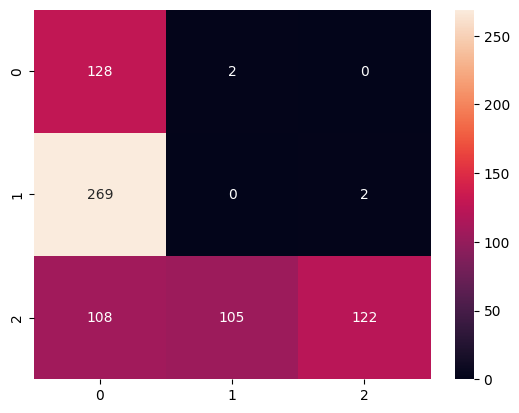

In [26]:
print('Shimmy Data Metrics')
display_metrics(shimmy_label, shimmy_pred)

In [27]:
tqdm.pandas()
cdf_pred = cdf_df_mini['text'].progress_apply(classify_with_ollama)
cdf_pred = cdf_pred.astype(int)

100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s]


In [28]:
cdf_df_mini['label'].value_counts().sort_index()

label
0    328
1    462
2    210
Name: count, dtype: int64

Shimmy Data Metrics
Accuracy Score:  0.565
              precision    recall  f1-score   support

           0       0.52      0.89      0.66       328
           1       0.62      0.46      0.53       462
           2       0.61      0.29      0.39       210

    accuracy                           0.56      1000
   macro avg       0.58      0.55      0.53      1000
weighted avg       0.59      0.56      0.54      1000



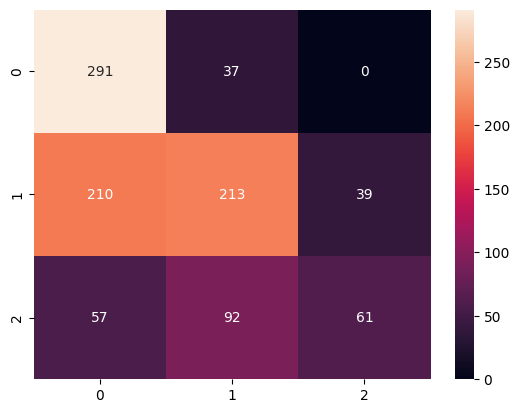

In [29]:
print('Shimmy Data Metrics')
display_metrics(cdf_df_mini['label'], cdf_pred)